In [1]:
import os
import glob

import numpy as np
import torch
from preprocessing import convert_spectrograms, convert_tensor
from model_ae import Encoder

In [2]:
encoder = Encoder('1d')
encoder.load_state_dict(torch.load('./output/aae_1d_step_300.pt'))
encoder.eval()

Encoder(
  (conv1): Sequential(
    (0): Conv1d(1, 4, kernel_size=(11, 1), stride=(1,))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(4, 4, kernel_size=(11, 1), stride=(1,))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv1d(4, 8, kernel_size=(11, 1), stride=(1,))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv1d(8, 8, kernel_size=(10, 1), stride=(1,))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [3]:
data_dir = './wav_data/pretrain/RAVDESS_resample/'

sample_datas = glob.glob(os.path.join(data_dir, '**', '*wav'), recursive=True)
sample_datas = sorted(sample_datas)

In [4]:
np.random.seed(42)
idx = np.random.permutation(len(sample_datas))
train_idx = idx[:int(len(sample_datas)*0.75)]
eval_idx = idx[int(len(sample_datas)*0.75):]

train_samples = list(np.array(sample_datas)[train_idx])
eval_samples = list(np.array(sample_datas)[eval_idx])

In [5]:
y = np.array(list(map(lambda x: int(x.split('/')[-1].split('-')[2]) - 1, sample_datas)))
y_train = y[train_idx]
y_eval = y[eval_idx]

In [6]:
X_train, y_train = convert_spectrograms(train_samples, conv_dim='1d', sr=16000, labels=y_train)
X_eval, y_eval = convert_spectrograms(eval_samples, conv_dim='1d', sr=16000, labels=y_eval)

1080it [00:06, 172.58it/s]
360it [00:01, 183.83it/s]


In [7]:
X_angry = X_eval[(y_eval == 4)]  # anger label
X_angry = convert_tensor(X_angry)

In [8]:
violence_dir = './wav_data/violence/'

violence_datas = glob.glob(os.path.join(violence_dir, '**', '*wav'), recursive=True)
violence_datas = sorted(violence_datas)

In [9]:
X_violence = convert_spectrograms(violence_datas, conv_dim='1d', sr=16000)
X_violence = convert_tensor(X_violence)

96it [00:21,  4.42it/s]


In [10]:
normal_dir = './wav_data/normal/'

normal_datas = glob.glob(os.path.join(normal_dir, '**', '*wav'), recursive=True)
normal_datas = sorted(normal_datas)

In [11]:
X_normal = convert_spectrograms(normal_datas, conv_dim='1d', sr=16000)
X_normal = convert_tensor(X_normal)

10it [00:01,  6.92it/s]


In [12]:
z_angry = encoder(X_angry)
z_violence = encoder(X_violence)
z_normal = encoder(X_normal)

In [13]:
z_angry = z_angry.reshape(z_angry.shape[0], -1)
z_violence = z_violence.reshape(z_violence.shape[0], -1)
z_normal = z_normal.reshape(z_normal.shape[0], -1)

In [14]:
z_angry = z_angry.detach().numpy()
z_violence = z_violence.detach().numpy()
z_normal= z_normal.detach().numpy()

z_total = np.concatenate([z_angry, z_violence, z_normal], axis=0)
z_total.shape

(6528, 400)

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(z_total)

In [16]:
n_angry = z_angry.shape[0]
n_violence = z_violence.shape[0]
n_normal = z_normal.shape[0]

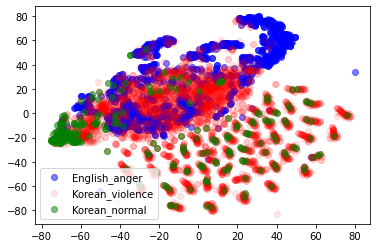

In [17]:
# IEMOCAP + RAVDESS + AI Hub
import matplotlib.pyplot as plt

plt.scatter(transformed[:n_angry, 0], transformed[:n_angry, 1], color='b', alpha=0.5, label='English_anger')
plt.scatter(transformed[n_angry:(n_angry+n_violence), 0], transformed[n_angry:(n_angry+n_violence), 1], 
            color='r', alpha=0.1, label='Korean_violence')
plt.scatter(transformed[(n_angry+n_violence):, 0], transformed[(n_angry+n_violence):, 1], 
            color='g', alpha=0.5, label='Korean_normal')
plt.legend()
plt.show()

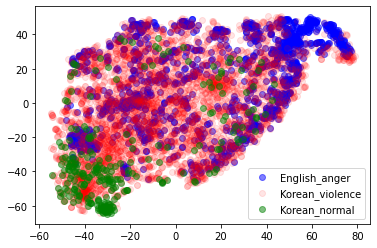

In [17]:
# IEMOCAP + RAVDESS
import matplotlib.pyplot as plt

plt.scatter(transformed[:n_angry, 0], transformed[:n_angry, 1], color='b', alpha=0.5, label='English_anger')
plt.scatter(transformed[n_angry:(n_angry+n_violence), 0], transformed[n_angry:(n_angry+n_violence), 1], 
            color='r', alpha=0.1, label='Korean_violence')
plt.scatter(transformed[(n_angry+n_violence):, 0], transformed[(n_angry+n_violence):, 1], 
            color='g', alpha=0.5, label='Korean_normal')
plt.legend()
plt.show()